Guardare Mixture Density Netwotk

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
POISS_SUPP = 50
torch.set_default_dtype(torch.float64)

In [39]:
class PoissonNetwork(nn.Module):
    def __init__(self, input_size=POISS_SUPP, num_component_output=2): 
        super(PoissonNetwork, self).__init__()
        self.input_size = input_size
        self.num_component_output = num_component_output
        self.flatten = nn.Flatten()
        self.network = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128,3*num_component_output)             # modified output to get 1 component only
        )

    def forward(self, x):
        output = self.network(x)
        pi = output[:, 0:self.num_component_output]
        mu = output[:, self.num_component_output:2*self.num_component_output]
        sigma = output[:, 2*self.num_component_output:3*self.num_component_output]

        pi = torch.softmax(pi, dim=1)
        sigma = torch.exp(sigma) #torch.relu(sigma)            # try relu
        mu = torch.exp(mu) #torch.relu(mu)           # try relu

        return pi, mu, sigma

In [4]:
def loss_function_minibatch_poisson(y_poisson, new_pi, new_mu, new_sigma):
    count = 0
    total_loss = 0
    for poisson_sample in y_poisson:
        #Generate the new gaussian mixture
        mix_new = torch.distributions.Categorical(new_pi[count])
        comp_new = torch.distributions.Normal(new_mu[count], new_sigma[count])
        gmm_new = torch.distributions.MixtureSameFamily(mix_new, comp_new)

        # Calculate the log likelihood of the new gaussian mixture with the old samples
        log_likelihood = torch.sum(gmm_new.log_prob(poisson_sample))
        #mean_diff = torch.abs(new_mu[count] - torch.mean(poisson_sample.float()))[0]
        total_loss -= 0.1*log_likelihood          # rescaled log_likelihood to make it comparable to mean_diff
        #total_loss += mean_diff                  # added regularization factor to ensure the sample mean and the estimated one are similar
        count += 1
    return total_loss/count


In [5]:
def train_loop_minibatch_poisson(training_dataloader, model, loss_fn, optimizer, n_samples=250):
    model.train()
    counter = 0
    
    for bach_idx, poisson_densities in enumerate(training_dataloader):
        y_poisson = []

        for density in poisson_densities:
            y_poisson.append(torch.distributions.Categorical(probs=density).sample((n_samples,)))
            pi_new, mu_new, sigma_new = model(poisson_densities)
            
        loss = loss_fn(y_poisson, pi_new, mu_new, sigma_new)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if counter % 100 == 0:
            loss = loss.item() #batch * batch_size + len(X)
            print(f"loss: {loss:>7f}")
        counter += 1


In [6]:
import torch.nn.functional as F
from torch.distributions.normal import Normal

def generate_poisson(pi, mu, sigma, end = POISS_SUPP):
    """
    Input:
    pi = tensor of weights of length c
    mu = tensor of means of length c
    sigma = tensor of variances of length c
    Taken as input the parameters of a Gaussian Mixtures returns the
    density of a Poisson distribution having as rate given mixture, truncated to [0, end]
    """
    c = len(pi)   # number of components in the mixture
    
    # initializes the density vector, storing a density for each component
    pois_dens = torch.zeros((c, end))
    # initializes the vector of factorials
    log_fact = torch.tensor([sum([torch.log(torch.tensor(float(i))) for i in range(1, n)]) for n in range(1, end+1)])
    
    # computes the Gaussian density for each component
    muprime = mu - sigma
    std = torch.sqrt(sigma)
    norm = Normal(torch.tensor(0.0), torch.tensor(1.0))

    for i in range(c):
        for k_val in range(end):
            if k_val == 0:
                pois_dens[i, k_val] = 1 - norm.cdf(-muprime[i]/std[i])
            elif k_val == 1:
                pois_dens[i, k_val] = muprime[i] * pois_dens[i, k_val-1] + std[i] * norm.log_prob(-muprime[i]/std[i]).exp()
            else:
                pois_dens[i, k_val] = (muprime[i] * pois_dens[i, k_val-1] + (k_val-1) * sigma[i] * pois_dens[i, k_val-2])
        # goes to logarithm to compute the factorial
        pois_dens[i, :] = torch.log(pois_dens[i, :]) - log_fact
        pois_dens[i, :] = pois_dens[i, :].exp()
        # multiplies by normalization constant
        pois_dens[i, :] = pois_dens[i, :] * torch.exp(0.5 * (sigma[i] - 2 * mu[i]))
        # puts missing probability mass to zero
        pois_dens[i, 0] += 1 - pois_dens[i, :].sum()

    # compute product between weights and densities per component
    pois_dens = pi.reshape(1, c).matmul(pois_dens).reshape(end, )
    return pois_dens


# Fitting with 1 component

In [7]:
# Define the number of samples in the dataset
num_samples = 10000

from scipy.stats import qmc

l_bounds = [0, 0.01] # lower bounds on mu and sigma
u_bounds = [10, 6]   # upper bounds on mu and sigma

sampler = qmc.LatinHypercube(d=2)   # d=5                           # changed the way it samples (is it correct?)
samples = sampler.random(n=num_samples)

samples = qmc.scale(samples, [0, 0.01], [10, 6])
dataset = torch.hstack([torch.ones(num_samples).reshape(num_samples,1), torch.tensor(samples)])
dataset

tensor([[1.0000, 2.6128, 3.3636],
        [1.0000, 3.0044, 2.5112],
        [1.0000, 0.4338, 3.1805],
        ...,
        [1.0000, 5.6027, 1.3101],
        [1.0000, 1.0155, 2.5085],
        [1.0000, 8.7149, 5.8957]])

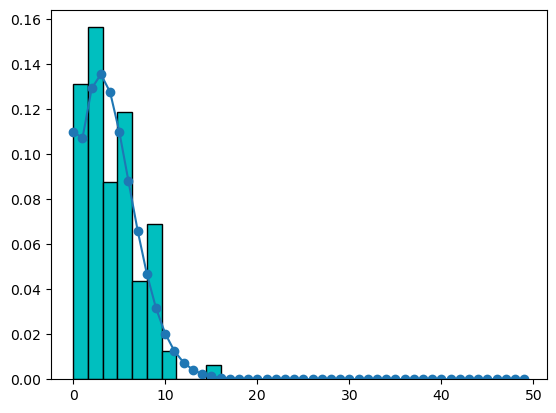

In [8]:
#Check how it works

pi = torch.tensor([1.])
mu = torch.tensor([4.])
sigma = torch.tensor([5.])

pois_dens = generate_poisson(pi, mu, sigma)
pois_dens

#sample 100 points from a categorical distribution with the weights pois_dens
sample = torch.distributions.Categorical(probs=pois_dens).sample((100,))

plt.hist(sample, bins=10, density=True, color='c', edgecolor='black')
plt.plot(range(50), pois_dens, marker= 'o')


In [9]:
training_data = dataset[:int(0.85*len(dataset))]

#build a tensor that replaces each of the rows of the training_data with the corresponding generate_poisson
def generate_poisson_dataset_dim1(training_data):
    #y_poisson = []
    poisson_densities = []
    for gaussian_mix_old in training_data:
        old_pi = torch.tensor([gaussian_mix_old[0]])
        old_mu = torch.tensor([gaussian_mix_old[1]])
        old_sigma = torch.tensor([gaussian_mix_old[2]])
        pois_dens = generate_poisson(old_pi, old_mu, old_sigma)
        #y_poisson.append(torch.distributions.Categorical(probs=torch.tensor(pois_dens)).sample((250,)))
        poisson_densities.append(pois_dens)
    return torch.stack(poisson_densities) #,torch.stack(y_poisson)

densities = generate_poisson_dataset_dim1(training_data)    # densities contiene le densità, y_poisson i samples

In [10]:
epochs = 100
model = PoissonNetwork(input_size=POISS_SUPP, num_component_output=1)

optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
train_dataloader = DataLoader(densities, batch_size=64)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop_minibatch_poisson(train_dataloader, model, loss_function_minibatch_poisson, optimizer)
    #test_loop(test_data, model, loss_function)
print("Done!")
torch.save(model, 'params/poisson_dim1.pth')

Epoch 1
-------------------------------
loss: 425.650913
loss: 69.074583
Epoch 2
-------------------------------
loss: 70.064306
loss: 66.087051
Epoch 3
-------------------------------
loss: 65.768410
loss: 60.719761
Epoch 4
-------------------------------
loss: 61.197997
loss: 60.249739
Epoch 5
-------------------------------
loss: 60.537485
loss: 60.288958
Epoch 6
-------------------------------
loss: 60.613964
loss: 60.164080
Epoch 7
-------------------------------
loss: 60.337160
loss: 60.232441
Epoch 8
-------------------------------
loss: 60.492833
loss: 60.285318
Epoch 9
-------------------------------
loss: 60.519760
loss: 60.121076
Epoch 10
-------------------------------
loss: 60.104224
loss: 60.243794
Epoch 11
-------------------------------
loss: 60.393927
loss: 59.772020
Epoch 12
-------------------------------
loss: 60.343730
loss: 60.031691
Epoch 13
-------------------------------
loss: 60.453338
loss: 60.228473
Epoch 14
-------------------------------
loss: 60.235983
lo

### Test

In [11]:
import torch
from torch import nn
#from neural_soga import *

import matplotlib.pyplot as plt
import numpy as np

Neural network: [[8.10249013]] [[1.8189848]]
SOGA values: 8.000000001822134 3.1622776557139574


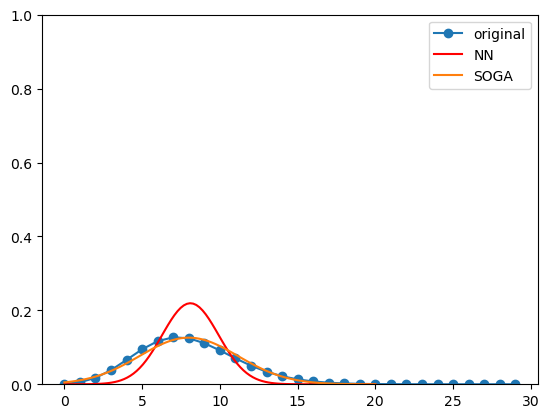

In [18]:
from scipy.stats import norm

model = PoissonNetwork(input_size=50, num_component_output=1)
model = torch.load('params/poisson_dim1.pth')

#Check with some distributions
# 1.0000, 5.4371, 0.0294
pi = torch.tensor([1.])
mu = torch.tensor([8.0])
sigma = torch.tensor([2])

pois_dens = generate_poisson(pi, mu, sigma)
plt.plot(range(30), pois_dens[0:30], marker= 'o', label='original')

pi_new, mu_new, sigma_new = model(pois_dens.reshape(1,50).double())
print('Neural network:', mu_new.detach().numpy(), torch.sqrt(sigma_new).detach().numpy())
mix_new = torch.distributions.Categorical(pi_new)
comp_new = torch.distributions.Normal(mu_new, torch.sqrt(sigma_new))
gmm_new = torch.distributions.MixtureSameFamily(mix_new, comp_new)

x = np.linspace(0,20,100)

plt.plot(x, gmm_new.log_prob(torch.tensor(x).reshape(100,1)).exp().detach().numpy(), color='r', label='NN')

pois_dens = pois_dens.detach().numpy()
pois_mean = sum([i*pois_dens[i] for i in range(len(pois_dens))])
pois_std = np.sqrt(sum([i**2*pois_dens[i] for i in range(len(pois_dens))]) - pois_mean**2)
print('SOGA values:', pois_mean, pois_std)
plt.plot(x, norm.pdf(x, loc=pois_mean, scale=pois_std), label='SOGA')
plt.ylim(0, 1)

plt.legend()

plt.savefig('poisson_fit_1comp_NN.png')

For some reason it does not guess the mean accurately

# Da qui in poi non eseguire

# Fitting with 2 components

In [27]:
# Define the number of samples in the dataset
num_samples = 10000

from scipy.stats import qmc


l_bounds = [0, 0, 0, 0.01, 0.01] # lower bounds on p1, mu1, mu2, sigma1 and sigma2
u_bounds = [1, 10, 10, 2, 2]   # upper bounds on p1, mu1, mu2, sigma1 and sigma2

sampler = qmc.LatinHypercube(d=5)   # d=5
samples = sampler.random(n=num_samples)

samples = qmc.scale(samples,l_bounds, u_bounds)
dataset = torch.hstack([torch.tensor(1-samples[:,0].reshape(num_samples,1)), torch.tensor(samples)])
dataset


tensor([[0.6992, 0.3008, 2.5403, 0.0762, 1.2924, 1.5191],
        [0.4670, 0.5330, 4.9460, 9.1671, 1.6209, 1.2838],
        [0.0356, 0.9644, 4.9440, 8.4632, 1.8922, 1.2834],
        ...,
        [0.6082, 0.3918, 8.6012, 8.9800, 1.5214, 1.5045],
        [0.6837, 0.3163, 7.6976, 0.4783, 1.4974, 1.9961],
        [0.0468, 0.9532, 0.8114, 1.8326, 0.7393, 1.4755]])

In [28]:
import torch.nn.functional as F
from torch.distributions.normal import Normal

def generate_poisson(pi, mu, sigma, end = POISS_SUPP):
    """
    Input:
    pi = tensor of weights of length c
    mu = tensor of means of length c
    sigma = tensor of variances of length c
    Taken as input the parameters of a Gaussian Mixtures returns the
    density of a Poisson distribution having as rate given mixture, truncated to [0, end]
    """
    c = len(pi)   # number of components in the mixture
    
    # initializes the density vector, storing a density for each component
    pois_dens = torch.zeros((c, end))
    # initializes the vector of factorials
    log_fact = torch.tensor([sum([torch.log(torch.tensor(float(i))) for i in range(1, n)]) for n in range(1, end+1)])
    
    # computes the Gaussian density for each component
    muprime = mu - sigma
    std = torch.sqrt(sigma)
    norm = Normal(torch.tensor(0.0), torch.tensor(1.0))

    for i in range(c):
        for k_val in range(end):
            if k_val == 0:
                pois_dens[i, k_val] = 1 - norm.cdf(-muprime[i]/std[i])
            elif k_val == 1:
                pois_dens[i, k_val] = muprime[i] * pois_dens[i, k_val-1] + std[i] * norm.log_prob(-muprime[i]/std[i]).exp()
            else:
                pois_dens[i, k_val] = (muprime[i] * pois_dens[i, k_val-1] + (k_val-1) * sigma[i] * pois_dens[i, k_val-2])
        # goes to logarithm to compute the factorial
        pois_dens[i, :] = torch.log(pois_dens[i, :]) - log_fact
        pois_dens[i, :] = pois_dens[i, :].exp()
        # multiplies by normalization constant
        pois_dens[i, :] = pois_dens[i, :] * torch.exp(0.5 * (sigma[i] - 2 * mu[i]))
        # puts missing probability mass to zero
        pois_dens[i, 0] += 1 - pois_dens[i, :].sum()

    # compute product between weights and densities per component
    pois_dens = pi.reshape(1, c).matmul(pois_dens).reshape(end, )
    return pois_dens


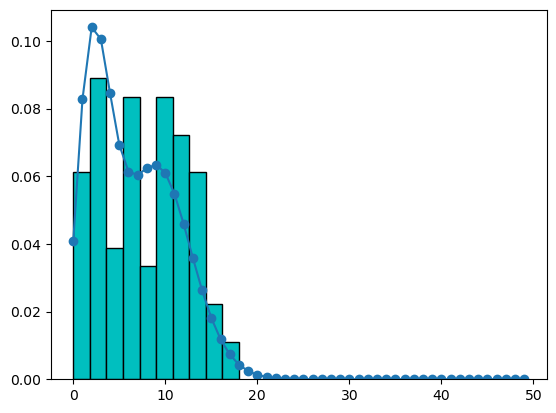

In [29]:
#Check how it works

pi = torch.tensor([0.5, 0.5])
mu = torch.tensor([3, 10])
sigma = torch.tensor([1, 1])

pois_dens = generate_poisson(pi, mu, sigma)
pois_dens

#sample 100 points from a categorical distribution with the weights pois_dens
sample = torch.distributions.Categorical(probs=pois_dens).sample((100,))

plt.hist(sample, bins=10, density=True, color='c', edgecolor='black')
plt.plot(range(50), pois_dens, marker= 'o')


In [30]:
def loss_function_minibatch_poisson(y_poisson, new_pi, new_mu, new_sigma):
    count = 0
    total_loss = 0
    for poisson_sample in y_poisson:
        #Generate the new gaussian mixture
        mix_new = torch.distributions.Categorical(new_pi[count])
        comp_new = torch.distributions.Normal(new_mu[count], new_sigma[count])
        gmm_new = torch.distributions.MixtureSameFamily(mix_new, comp_new)

    
        # Calculate the log likelihood of the new gaussian mixture with the old samples
        log_likelihood = torch.sum(gmm_new.log_prob(poisson_sample))
        total_loss -= log_likelihood
        count += 1
    return total_loss/count


In [35]:
def train_loop_minibatch_poisson(training_dataloader, model, loss_fn, optimizer, n_samples=250):
    model.train()
    counter = 0
    
    for bach_idx, poisson_denisties in enumerate(training_dataloader):
        y_poisson = []

        for density in poisson_denisties:
            y_poisson.append(torch.distributions.Categorical(probs=density).sample((n_samples,)))
            mu_new, pi_new, sigma_new = model(poisson_denisties)
            
        loss = loss_fn(y_poisson, pi_new, mu_new, sigma_new)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if counter % 100 == 0:
            loss = loss.item() #batch * batch_size + len(X)
            print(f"loss: {loss:>7f}")
        counter += 1



In [34]:
training_data = dataset[:int(0.85*len(dataset))]

#build a tensor that replaces each of the rows of the training_data with the corresponding generate_poisson
def generate_poisson_dataset(training_data):
    y_poisson = []
    poisson_denisties = []
    for gaussian_mix_old in training_data:
        old_pi = gaussian_mix_old[0:2]
        old_mu = gaussian_mix_old[2:4]
        old_sigma = gaussian_mix_old[4:6]
        pois_dens = generate_poisson(old_pi, old_mu, old_sigma)
        #y_poisson.append(torch.distributions.Categorical(probs=torch.tensor(pois_dens)).sample((250,)))
        poisson_denisties.append(pois_dens)
    return torch.stack(poisson_denisties)#,torch.stack(y_poisson)


densities = generate_poisson_dataset(training_data)    # densities contiene le densità, y_poisson i samples

In [36]:
densities

tensor([[3.1476e-01, 1.8325e-01, 1.6891e-01,  ..., 2.0980e-26, 3.7068e-27,
         6.4775e-28],
        [7.5651e-03, 2.5682e-02, 5.0692e-02,  ..., 3.1393e-16, 8.2881e-17,
         2.1559e-17],
        [1.0377e-03, 4.7763e-03, 1.3878e-02,  ..., 7.8591e-17, 1.9923e-17,
         4.9776e-18],
        ...,
        [1.6954e-02, 6.1922e-02, 1.2056e-01,  ..., 1.9859e-24, 3.5166e-25,
         6.1486e-26],
        [1.2010e-02, 3.8934e-02, 7.6744e-02,  ..., 1.5669e-19, 3.6431e-20,
         8.3616e-21],
        [2.3820e-01, 6.2221e-02, 4.9442e-02,  ..., 1.4827e-18, 3.5944e-19,
         8.5988e-20]])

In [45]:
epochs = 100
model = PoissonNetwork(input_size=POISS_SUPP, num_component_output=2)

optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
train_dataloader = DataLoader(densities, batch_size=32)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop_minibatch_poisson(train_dataloader, model, loss_function_minibatch_poisson, optimizer, n_samples=500)
    #test_loop(test_data, model, loss_function)
print("Done!")
torch.save(model, 'model4.pth')

Epoch 1
-------------------------------
loss: 9614.674234
loss: 1596.594583
loss: 1589.536076
Epoch 2
-------------------------------
loss: 1600.396366
loss: 1594.394826
loss: 1495.759830
Epoch 3
-------------------------------
loss: 1528.507462
loss: 1459.378918
loss: 1493.068614
Epoch 4
-------------------------------
loss: 1546.981481
loss: 1448.642930
loss: 1488.549127
Epoch 5
-------------------------------
loss: 1526.267799
loss: 1444.145732
loss: 1483.141064
Epoch 6
-------------------------------
loss: 1527.623636
loss: 1442.750426
loss: 1476.039583
Epoch 7
-------------------------------
loss: 1514.965295
loss: 1447.529363
loss: 1463.535404
Epoch 8
-------------------------------
loss: 1515.952928
loss: 1446.552550
loss: 1478.779952
Epoch 9
-------------------------------
loss: 1515.302848
loss: 1437.564317
loss: 1464.486281
Epoch 10
-------------------------------
loss: 1518.219675
loss: 1443.687886
loss: 1468.527590
Epoch 11
-------------------------------
loss: 1511.319251


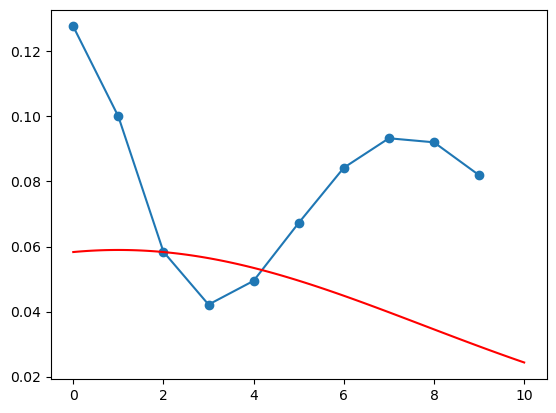

In [46]:
#Check with some distributions
pi = torch.tensor([0.3, 0.7])
mu = torch.tensor([0.95, 8])
sigma = torch.tensor([0.2, 1])

pois_dens = generate_poisson(pi, mu, sigma)
plt.plot(range(10), pois_dens[0:10], marker= 'o')

mu_new, pi_new, sigma_new = model(pois_dens.reshape(1,50))
mix_new = torch.distributions.Categorical(pi_new)
comp_new = torch.distributions.Normal(mu_new, sigma_new)
gmm_new = torch.distributions.MixtureSameFamily(mix_new, comp_new)

plt.plot(np.linspace(0, 10, 100), gmm_new.log_prob(torch.tensor(np.linspace(0, 10, 100)).reshape(100,1)).exp().detach().numpy(), color='r')
#plt.ylim(0, 1)
